In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
with open('config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = config["source_epochs"]
LR = 1e-4
IN_SHAPE = config["image_shape"]
MAGNIFICATION = config["magnification"]
N_MAG = config["n_magnification"]
center_disp, center_scale, amp_scale, amp_disp = config["lens_centers_disp"], config["lens_centers_scale"], config["lens_amp_scale"], config["lens_amp_disp"]
resolution = config["resolution"]/(MAGNIFICATION*N_MAG)
source_scaling = config["source_scaling"]

In [4]:
BATCH_SIZE = 5
dataset = data.LensingDataset('/home/anirudh/Documents/GSoC/DeepLense_2024/Simulations/data_model_1/',['no_sub'],5000)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

In [5]:
i_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["i_depth"], in_channels=1, latent_channel_count=config["i_latent_channels"]).to(device)
s_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["s_depth"], in_channels=1, latent_channel_count=config["i_latent_channels"]).to(device)

alpha = torch.tensor([[config["alpha"] for _ in range(IN_SHAPE*MAGNIFICATION*N_MAG)] for __ in range(IN_SHAPE*MAGNIFICATION*N_MAG)]).to(device)
phy_loss = models.LensingLoss(in_shape=IN_SHAPE*MAGNIFICATION*N_MAG,device=device,alpha=alpha, resolution=resolution, BATCH_SIZE=BATCH_SIZE, source_scaling=source_scaling).to(device)

opt = torch.optim.Adam(params=s_model.parameters(),lr=LR)
total_params = sum(p.numel() for p in s_model.parameters())
print(f"Number of parameters: {total_params}x2")

Number of parameters: 899843x2


In [6]:
def give_random_image(dataset, model1, model2, length):
    """
    To display a random image for illustration

    :param dataset: Dataset used
    :param model: Model used
    :param length: Length of dataset used
    :return: original LR image, SR image, original HR image
    """
    i = np.random.randint(low=0,high=length)
    LR = dataset[i]
    t = LR.clone().detach().view(1,1,IN_SHAPE,IN_SHAPE)
    t1 = model1(t.float().to(device)).cpu().detach()
    t2 = model2(t.float().to(device)).cpu().detach()
    image1 = Image.fromarray(t1.numpy()[0][0]*255)
    image2 = Image.fromarray(t2.numpy()[0][0]*255)
    image3, image4 = phy_loss.get_samples(t1.to(device))
    return (Image.fromarray(t.numpy()[0][0]*255), image1, image2, Image.fromarray(image3.cpu().numpy()[0][0]*255), Image.fromarray(image4.cpu().numpy()[0][0]*255))

def show_random_image(image_tuple):
    image0, image1, image2, image3, image4 = image_tuple[0], image_tuple[1], image_tuple[2], image_tuple[3], image_tuple[4]
    plot, axes = plt.subplots(1,5)
    plot.set_size_inches(30,6)
    axes[0].imshow(image0)
    axes[1].imshow(image1)
    axes[2].imshow(image2)
    axes[3].imshow(image3)
    axes[4].imshow(image4)
    axes[0].set_title("LR")
    axes[1].set_title("Image")
    axes[2].set_title("Source_network")
    axes[3].set_title("Source_regenerated")
    axes[4].set_title("Source_true")

In [7]:
i_model.load_state_dict(torch.load('bicubic.pt'))

<All keys matched successfully>

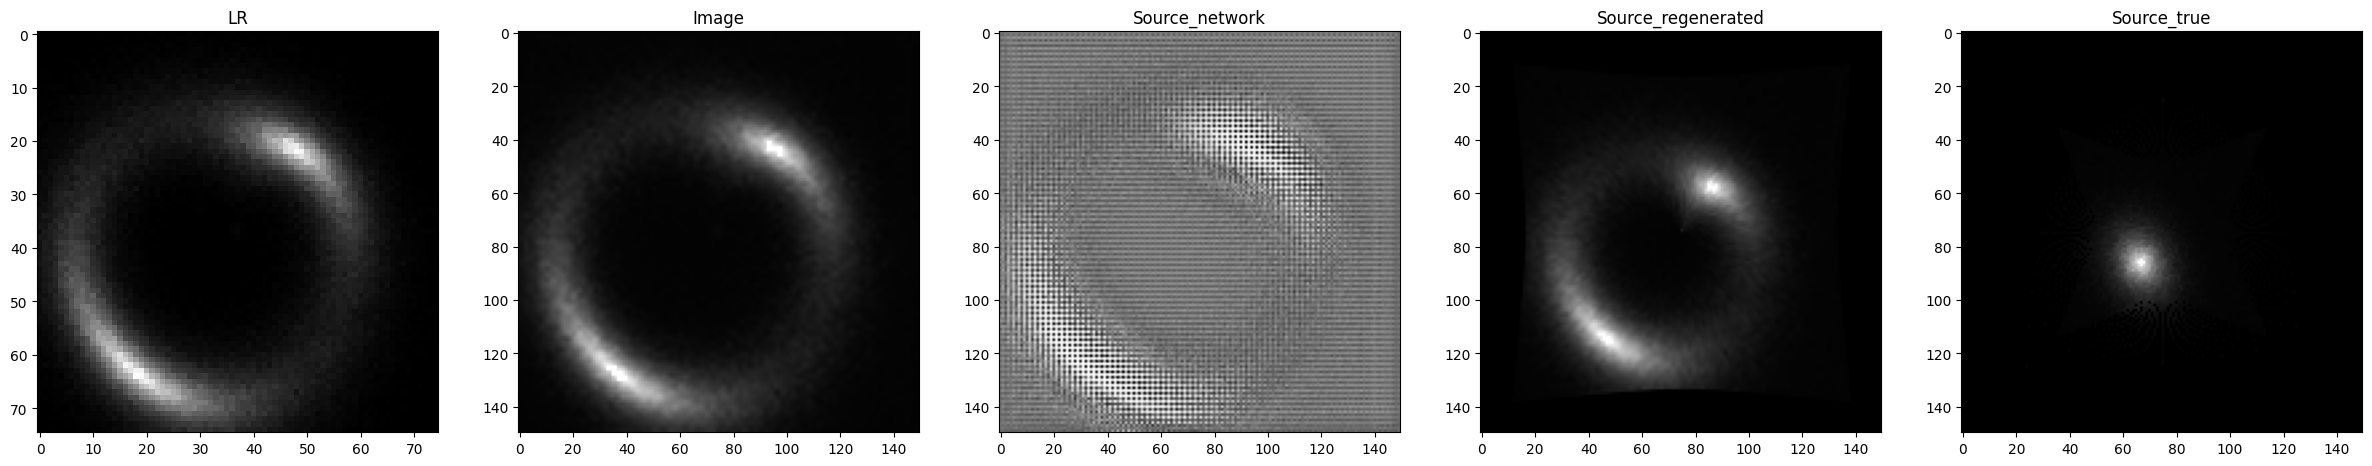

In [8]:
show_random_image(give_random_image(val_dataset, i_model, s_model, len(val_dataset)))

In [9]:
best_val_loss = np.inf
best_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[]}
for epoch in range(EPOCHS):
    losses = []
    i_model.eval()
    s_model.train()
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        image = i_model(x)
        source = s_model(x)
        loss = phy_loss(source, image, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses))
    i_model.eval()
    s_model.eval()
    losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (x.float().to(device))
        image = i_model(x)
        source = s_model(x)
        # k_tensor = k_model(x)
        val_loss = phy_loss(source, image, x)
        losses.append(float(val_loss))
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = s_model.state_dict()
    history['val_loss'].append(np.mean(losses))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")

Training epoch 1: 100%|██████████| 800/800 [01:05<00:00, 12.14it/s]


Training at epoch 1/50: 0.2735574857518077 at LR=0.0001


Validation epoch 1: 100%|██████████| 200/200 [00:05<00:00, 33.39it/s]


Validation at epoch 1/50: 0.24225365191698076 at LR=0.0001


Training epoch 2: 100%|██████████| 800/800 [01:05<00:00, 12.12it/s]


Training at epoch 2/50: 0.23884720530360937 at LR=0.0001


Validation epoch 2: 100%|██████████| 200/200 [00:06<00:00, 33.31it/s]


Validation at epoch 2/50: 0.23799788743257522 at LR=0.0001


Training epoch 3: 100%|██████████| 800/800 [01:06<00:00, 12.08it/s]


Training at epoch 3/50: 0.2113484083302319 at LR=0.0001


Validation epoch 3: 100%|██████████| 200/200 [00:06<00:00, 33.00it/s]


Validation at epoch 3/50: 0.2050828719884157 at LR=0.0001


Training epoch 4: 100%|██████████| 800/800 [01:06<00:00, 12.04it/s]


Training at epoch 4/50: 0.1865402564778924 at LR=0.0001


Validation epoch 4: 100%|██████████| 200/200 [00:06<00:00, 32.68it/s]


Validation at epoch 4/50: 0.16349372141063212 at LR=0.0001


Training epoch 5: 100%|██████████| 800/800 [01:06<00:00, 12.01it/s]


Training at epoch 5/50: 0.16452506510540843 at LR=0.0001


Validation epoch 5: 100%|██████████| 200/200 [00:06<00:00, 32.93it/s]


Validation at epoch 5/50: 0.1643380256742239 at LR=0.0001


Training epoch 6: 100%|██████████| 800/800 [01:06<00:00, 12.02it/s]


Training at epoch 6/50: 0.1446586271841079 at LR=0.0001


Validation epoch 6: 100%|██████████| 200/200 [00:06<00:00, 32.94it/s]


Validation at epoch 6/50: 0.13117161549627782 at LR=0.0001


Training epoch 7: 100%|██████████| 800/800 [01:06<00:00, 12.01it/s]


Training at epoch 7/50: 0.12697682208381594 at LR=0.0001


Validation epoch 7: 100%|██████████| 200/200 [00:06<00:00, 32.97it/s]


Validation at epoch 7/50: 0.11617290414869785 at LR=0.0001


Training epoch 8: 100%|██████████| 800/800 [01:06<00:00, 12.01it/s]


Training at epoch 8/50: 0.11113115591928363 at LR=0.0001


Validation epoch 8: 100%|██████████| 200/200 [00:06<00:00, 32.90it/s]


Validation at epoch 8/50: 0.10078597214072943 at LR=0.0001


Training epoch 9: 100%|██████████| 800/800 [01:06<00:00, 11.99it/s]


Training at epoch 9/50: 0.09700098332948982 at LR=0.0001


Validation epoch 9: 100%|██████████| 200/200 [00:06<00:00, 32.39it/s]


Validation at epoch 9/50: 0.08887713849544525 at LR=0.0001


Training epoch 10: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 10/50: 0.08444153376389295 at LR=0.0001


Validation epoch 10: 100%|██████████| 200/200 [00:06<00:00, 32.67it/s]


Validation at epoch 10/50: 0.07483238257467746 at LR=0.0001


Training epoch 11: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 11/50: 0.0733109338209033 at LR=0.0001


Validation epoch 11: 100%|██████████| 200/200 [00:06<00:00, 32.88it/s]


Validation at epoch 11/50: 0.07537003554403782 at LR=0.0001


Training epoch 12: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 12/50: 0.06348654510453343 at LR=0.0001


Validation epoch 12: 100%|██████████| 200/200 [00:06<00:00, 32.84it/s]


Validation at epoch 12/50: 0.05561374546959996 at LR=0.0001


Training epoch 13: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 13/50: 0.0548298231465742 at LR=0.0001


Validation epoch 13: 100%|██████████| 200/200 [00:06<00:00, 32.83it/s]


Validation at epoch 13/50: 0.047216187827289105 at LR=0.0001


Training epoch 14: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 14/50: 0.047183704078197476 at LR=0.0001


Validation epoch 14: 100%|██████████| 200/200 [00:06<00:00, 32.77it/s]


Validation at epoch 14/50: 0.03855692205950618 at LR=0.0001


Training epoch 15: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 15/50: 0.0405496040568687 at LR=0.0001


Validation epoch 15: 100%|██████████| 200/200 [00:06<00:00, 32.64it/s]


Validation at epoch 15/50: 0.03718999611213803 at LR=0.0001


Training epoch 16: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 16/50: 0.03470827335026115 at LR=0.0001


Validation epoch 16: 100%|██████████| 200/200 [00:06<00:00, 32.81it/s]


Validation at epoch 16/50: 0.029637904018163682 at LR=0.0001


Training epoch 17: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 17/50: 0.029685262721031905 at LR=0.0001


Validation epoch 17: 100%|██████████| 200/200 [00:06<00:00, 32.73it/s]


Validation at epoch 17/50: 0.028114555031061174 at LR=0.0001


Training epoch 18: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 18/50: 0.025269887365866453 at LR=0.0001


Validation epoch 18: 100%|██████████| 200/200 [00:06<00:00, 32.69it/s]


Validation at epoch 18/50: 0.02904014891013503 at LR=0.0001


Training epoch 19: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 19/50: 0.021503229985246435 at LR=0.0001


Validation epoch 19: 100%|██████████| 200/200 [00:06<00:00, 32.75it/s]


Validation at epoch 19/50: 0.019178118808194995 at LR=0.0001


Training epoch 20: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 20/50: 0.018242528273258358 at LR=0.0001


Validation epoch 20: 100%|██████████| 200/200 [00:06<00:00, 32.84it/s]


Validation at epoch 20/50: 0.015070724347606302 at LR=0.0001


Training epoch 21: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 21/50: 0.015443919274257496 at LR=0.0001


Validation epoch 21: 100%|██████████| 200/200 [00:06<00:00, 32.62it/s]


Validation at epoch 21/50: 0.014875944373197853 at LR=0.0001


Training epoch 22: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 22/50: 0.01303001407184638 at LR=0.0001


Validation epoch 22: 100%|██████████| 200/200 [00:06<00:00, 32.83it/s]


Validation at epoch 22/50: 0.012025622697547079 at LR=0.0001


Training epoch 23: 100%|██████████| 800/800 [01:06<00:00, 11.94it/s]


Training at epoch 23/50: 0.011018568522995337 at LR=0.0001


Validation epoch 23: 100%|██████████| 200/200 [00:06<00:00, 32.66it/s]


Validation at epoch 23/50: 0.01301081949379295 at LR=0.0001


Training epoch 24: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 24/50: 0.00929458487429656 at LR=0.0001


Validation epoch 24: 100%|██████████| 200/200 [00:06<00:00, 32.71it/s]


Validation at epoch 24/50: 0.0077505050809122625 at LR=0.0001


Training epoch 25: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 25/50: 0.007811495286878198 at LR=0.0001


Validation epoch 25: 100%|██████████| 200/200 [00:06<00:00, 32.66it/s]


Validation at epoch 25/50: 0.0059965489595197145 at LR=0.0001


Training epoch 26: 100%|██████████| 800/800 [01:06<00:00, 11.94it/s]


Training at epoch 26/50: 0.006566843523760326 at LR=0.0001


Validation epoch 26: 100%|██████████| 200/200 [00:06<00:00, 32.42it/s]


Validation at epoch 26/50: 0.005633374773897231 at LR=0.0001


Training epoch 27: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 27/50: 0.005513151754566934 at LR=0.0001


Validation epoch 27: 100%|██████████| 200/200 [00:06<00:00, 32.62it/s]


Validation at epoch 27/50: 0.007076292512938381 at LR=0.0001


Training epoch 28: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 28/50: 0.004648900267202407 at LR=0.0001


Validation epoch 28: 100%|██████████| 200/200 [00:06<00:00, 32.41it/s]


Validation at epoch 28/50: 0.0037391152279451488 at LR=0.0001


Training epoch 29: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 29/50: 0.00398547898279503 at LR=0.0001


Validation epoch 29: 100%|██████████| 200/200 [00:06<00:00, 32.67it/s]


Validation at epoch 29/50: 0.003999981316737831 at LR=0.0001


Training epoch 30: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 30/50: 0.0033364872739184647 at LR=0.0001


Validation epoch 30: 100%|██████████| 200/200 [00:06<00:00, 32.50it/s]


Validation at epoch 30/50: 0.003152999707963318 at LR=0.0001


Training epoch 31: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 31/50: 0.002906289019738324 at LR=0.0001


Validation epoch 31: 100%|██████████| 200/200 [00:06<00:00, 32.40it/s]


Validation at epoch 31/50: 0.00227409444807563 at LR=0.0001


Training epoch 32: 100%|██████████| 800/800 [01:07<00:00, 11.92it/s]


Training at epoch 32/50: 0.0025502682835212907 at LR=0.0001


Validation epoch 32: 100%|██████████| 200/200 [00:06<00:00, 32.56it/s]


Validation at epoch 32/50: 0.002290004240348935 at LR=0.0001


Training epoch 33: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 33/50: 0.002128811579896137 at LR=0.0001


Validation epoch 33: 100%|██████████| 200/200 [00:06<00:00, 32.44it/s]


Validation at epoch 33/50: 0.001902711378643289 at LR=0.0001


Training epoch 34: 100%|██████████| 800/800 [01:07<00:00, 11.92it/s]


Training at epoch 34/50: 0.0018901451108104084 at LR=0.0001


Validation epoch 34: 100%|██████████| 200/200 [00:06<00:00, 32.60it/s]


Validation at epoch 34/50: 0.0013870081707136705 at LR=0.0001


Training epoch 35: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 35/50: 0.0017059680282545742 at LR=0.0001


Validation epoch 35: 100%|██████████| 200/200 [00:06<00:00, 32.48it/s]


Validation at epoch 35/50: 0.0013434745883569121 at LR=0.0001


Training epoch 36: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 36/50: 0.0015394430558080786 at LR=0.0001


Validation epoch 36: 100%|██████████| 200/200 [00:06<00:00, 32.61it/s]


Validation at epoch 36/50: 0.001502829102682881 at LR=0.0001


Training epoch 37: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 37/50: 0.001410717991529964 at LR=0.0001


Validation epoch 37: 100%|██████████| 200/200 [00:06<00:00, 32.71it/s]


Validation at epoch 37/50: 0.0011474039559834636 at LR=0.0001


Training epoch 38: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 38/50: 0.0012866730545647443 at LR=0.0001


Validation epoch 38: 100%|██████████| 200/200 [00:06<00:00, 32.64it/s]


Validation at epoch 38/50: 0.0014787609421182423 at LR=0.0001


Training epoch 39: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 39/50: 0.0012435384859418265 at LR=0.0001


Validation epoch 39: 100%|██████████| 200/200 [00:06<00:00, 32.53it/s]


Validation at epoch 39/50: 0.0013356189653859474 at LR=0.0001


Training epoch 40: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 40/50: 0.0012550480130448704 at LR=0.0001


Validation epoch 40: 100%|██████████| 200/200 [00:06<00:00, 32.61it/s]


Validation at epoch 40/50: 0.001310925621946808 at LR=0.0001


Training epoch 41: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 41/50: 0.001100736658263486 at LR=0.0001


Validation epoch 41: 100%|██████████| 200/200 [00:06<00:00, 32.58it/s]


Validation at epoch 41/50: 0.001028755416336935 at LR=0.0001


Training epoch 42: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 42/50: 0.0010960623573191698 at LR=0.0001


Validation epoch 42: 100%|██████████| 200/200 [00:06<00:00, 32.43it/s]


Validation at epoch 42/50: 0.0009936787042533978 at LR=0.0001


Training epoch 43: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 43/50: 0.0010600599841563963 at LR=0.0001


Validation epoch 43: 100%|██████████| 200/200 [00:06<00:00, 32.32it/s]


Validation at epoch 43/50: 0.0009950085819582454 at LR=0.0001


Training epoch 44: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 44/50: 0.0010617890728462952 at LR=0.0001


Validation epoch 44: 100%|██████████| 200/200 [00:06<00:00, 32.71it/s]


Validation at epoch 44/50: 0.0009096801071427763 at LR=0.0001


Training epoch 45: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 45/50: 0.0011045449395169272 at LR=0.0001


Validation epoch 45: 100%|██████████| 200/200 [00:06<00:00, 32.52it/s]


Validation at epoch 45/50: 0.000933835185423959 at LR=0.0001


Training epoch 46: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 46/50: 0.0010008884619310265 at LR=0.0001


Validation epoch 46: 100%|██████████| 200/200 [00:06<00:00, 32.57it/s]


Validation at epoch 46/50: 0.000923741115257144 at LR=0.0001


Training epoch 47: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 47/50: 0.001001038028334733 at LR=0.0001


Validation epoch 47: 100%|██████████| 200/200 [00:06<00:00, 32.51it/s]


Validation at epoch 47/50: 0.0008856202842434869 at LR=0.0001


Training epoch 48: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 48/50: 0.0009762103734828997 at LR=0.0001


Validation epoch 48: 100%|██████████| 200/200 [00:06<00:00, 32.67it/s]


Validation at epoch 48/50: 0.0009081426309421658 at LR=0.0001


Training epoch 49: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 49/50: 0.0009979431447573006 at LR=0.0001


Validation epoch 49: 100%|██████████| 200/200 [00:06<00:00, 32.61it/s]


Validation at epoch 49/50: 0.0008870813378598541 at LR=0.0001


Training epoch 50: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 50/50: 0.000984530384230311 at LR=0.0001


Validation epoch 50: 100%|██████████| 200/200 [00:06<00:00, 32.56it/s]

Validation at epoch 50/50: 0.0010827423169394023 at LR=0.0001


In [10]:
s_model.load_state_dict(best_weights)
torch.save(s_model.state_dict(),'s_weight.pt')

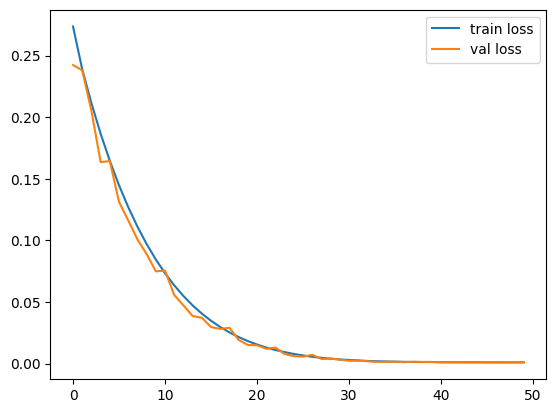

In [11]:
plt.plot(history['loss'],label='train loss')
plt.plot(history['val_loss'],label='val loss')
plt.legend()

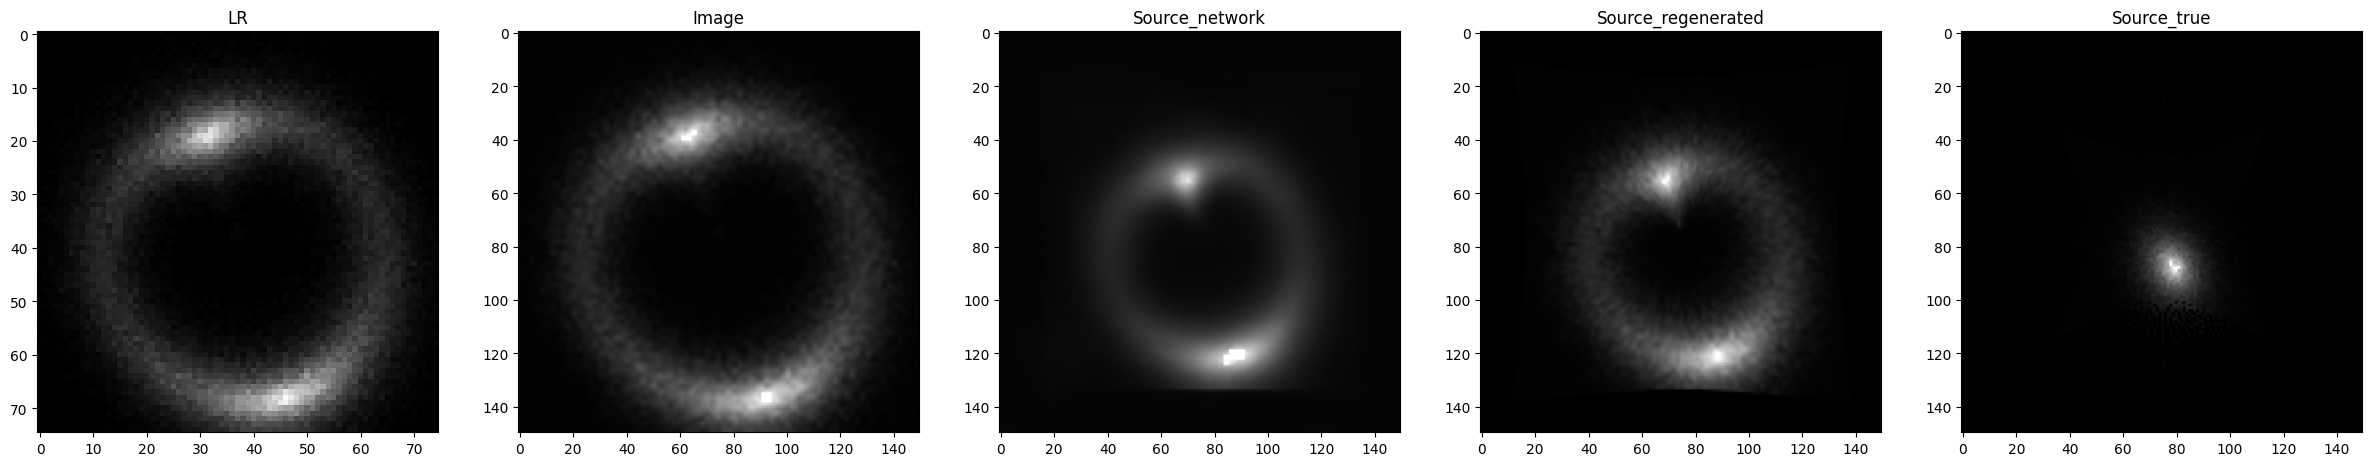

In [12]:
show_random_image(give_random_image(val_dataset, i_model, s_model, len(val_dataset)))